In [16]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import time
import matplotlib.pyplot as plt
from numpy import newaxis

def load_data(data_path,P,step):
    num_logs = P+step
    df = pd.read_csv(data_path)
    

    data_np = np.zeros((len(df),num_logs))
    data_df_combined = pd.DataFrame(data_np)
    data_df_combined.loc[:,0] = df['SYSLoad'].values

    for i in range(1, num_logs):
        data_df_combined.loc[:,i] = data_df_combined.shift(-i)

    data_df_combined_clean = data_df_combined.dropna()
    data_df_combined_clean = data_df_combined_clean.reset_index()
    data_df_combined_clean.drop('index',axis=1,inplace=True)
    data_combined_standardized = preprocessing.scale(data_df_combined_clean)

    train_split = round(0.8 * data_combined_standardized.shape[0])
    val_split = round(0.9 * data_combined_standardized.shape[0])
    print("all len",data_combined_standardized.shape[0])
    print("train_split",train_split)

    X = data_combined_standardized[:,:P]
    Y = data_combined_standardized[:,P:]

    X_train = X[:train_split]
    Y_train = Y[:train_split]
    X_test = X[train_split:]
    Y_test = Y[train_split:]

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],1))

    return X_train,Y_train,X_test,Y_test,data_df_combined_clean


In [17]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

use_cuda = torch.cuda.is_available()

class TorchDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

class TorchDataLoader:
    def __init__(self,batch_size,shuffle = True):
        self.batch_size = batch_size
        self.shuffle = shuffle
    
    def torch_dataloader(self,train_data,target_data):
        torch_dataset = TorchDataset(train_data,target_data)
        torch_loader = DataLoader(dataset = torch_dataset,
                                batch_size = self.batch_size, 
                                shuffle = self.shuffle)
        return torch_loader

def plot_results(predicted_data, true_data):
    # use in train.py 
    # plot evaluate result
    fig = plt.figure(facecolor='white', figsize=(12, 6))
    ax = fig.add_subplot(111)
    ax.plot(true_data[-200:], label='True Data')
    plt.plot(predicted_data[-200:], label='Prediction')
    plt.legend()
    plt.show()

def ToVariable(x):
    # use in train.py 
    # change from numpy.array to torch.variable   
    tmp = torch.DoubleTensor(x)
    return Variable(tmp)


In [18]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.nn.parameter import Parameter
import torch.nn.functional as F 
from torch.autograd import Variable
import torch.optim as optim
import numpy as np 
import h5py
from torch.utils.data import DataLoader, Dataset
import pywt


class Wavelet_LSTM(nn.Module):
    def __init__(self,seq_len, hidden_size,output_size):
        super(Wavelet_LSTM,self).__init__()
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.mWDN1_H = nn.Linear(seq_len,seq_len)
        self.mWDN1_L = nn.Linear(seq_len,seq_len)
        self.mWDN2_H = nn.Linear(int(seq_len/2),int(seq_len/2))
        self.mWDN2_L = nn.Linear(int(seq_len/2),int(seq_len/2))
        self.a_to_x = nn.AvgPool1d(2)
        self.sigmoid = nn.Sigmoid()
        self.lstm_xh1 = nn.LSTM(1,hidden_size,batch_first=True)
        self.lstm_xh2 = nn.LSTM(1,hidden_size,batch_first=True)
        self.lstm_xl2 = nn.LSTM(1,hidden_size,batch_first=True)
        self.output = nn.Linear(hidden_size,output_size)
        
        wavelet = pywt.Wavelet('db4')
        low = wavelet.dec_lo
        high = wavelet.dec_hi
        self.l_filter = low
        self.h_filter = high

        self.cmp_mWDN1_H = ToVariable(self.create_W(seq_len,False,is_comp=True))
        self.cmp_mWDN1_L = ToVariable(self.create_W(seq_len,True,is_comp=True))
        self.cmp_mWDN2_H = ToVariable(self.create_W(int(seq_len/2),False,is_comp=True))
        self.cmp_mWDN2_L = ToVariable(self.create_W(int(seq_len/2),True,is_comp=True))

        self.mWDN1_H.weight = torch.nn.Parameter(ToVariable(self.create_W(seq_len,False)))
        self.mWDN1_L.weight = torch.nn.Parameter(ToVariable(self.create_W(seq_len,True)))
        self.mWDN2_H.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/2),False)))
        self.mWDN2_L.weight = torch.nn.Parameter(ToVariable(self.create_W(int(seq_len/2),True)))

    def forward(self,input,h1,c1,h2,c2,h3,c3):
        input = input.view(input.shape[0],input.shape[1])
        ah_1 = self.sigmoid(self.mWDN1_H(input))
        al_1 = self.sigmoid(self.mWDN1_L(input))
        xh_1 = self.a_to_x(ah_1.view(ah_1.shape[0],1,-1))
        xl_1 = self.a_to_x(al_1.view(al_1.shape[0],1,-1))
        
        ah_2 = self.sigmoid(self.mWDN2_H(xl_1))
        al_2 = self.sigmoid(self.mWDN2_L(xl_1))
        
        xh_2 = self.a_to_x(ah_2)
        xl_2 = self.a_to_x(al_2)

        xh_1 = xh_1.transpose(1,2)
        xh_2 = xh_2.transpose(1,2)
        xl_2 = xl_2.transpose(1,2)

        level1_lstm,(h1,c1) = self.lstm_xh1(xh_1,(h1,c1))
        level2_lstm_h,(h2,c2) = self.lstm_xh2(xh_2,(h2,c2))
        level2_lstm_l,(h3,c3) = self.lstm_xl2(xl_2,(h3,c3))

        output = self.output(torch.cat((level1_lstm,level2_lstm_h,level2_lstm_l), 1))
        #output = output.view(-1,1)
        return output,h1,c1,h2,c2,h3,c3

    def init_state(self,batch_size):
        h1 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()
        c1 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()

        h2 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()
        c2 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()

        h3 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()
        c3 = Variable(torch.zeros(1,batch_size,self.hidden_size)).double()
        return h1,c1,h2,c2,h3,c3

    def create_W(self,P,is_l,is_comp=False):
        if is_l : 
            filter_list = self.l_filter
        else:
            filter_list = self.h_filter

        list_len = len(filter_list)

        max_epsilon = np.min(np.abs(filter_list))
        if is_comp:
            weight_np = np.zeros((P,P))
        else:
            weight_np = np.random.randn(P,P)*0.1*max_epsilon

        for i in range(0,P):
            filter_index = 0
            for j in range(i,P):
                if filter_index < len(filter_list):
                    weight_np[i][j] = filter_list[filter_index]
                    filter_index += 1
        return weight_np

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

def train(model,x_train,y_train,epochs=10,batch_size=32,alpha=0.3,beta=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.008)
    criterion = nn.MSELoss()

    torch_dataloader = TorchDataLoader(batch_size)
    train_loader = torch_dataloader.torch_dataloader(x_train,y_train)

    x_len = x_train.shape[1]
    for epoch in range(0,epochs):
        model.train()
        for batch,(X,Y) in enumerate(train_loader):
            h1,c1,h2,c2,h3,c3 = model.init_state(X.shape[0])
            out_put,h1,c1,h2,c2,h3,c3 = model(X,h1,c1,h2,c2,h3,c3)

            W_mWDN1_H = model.mWDN1_H.weight.data
            W_mWDN1_L = model.mWDN1_L.weight.data
            W_mWDN2_H = model.mWDN2_H.weight.data
            W_mWDN2_L = model.mWDN2_L.weight.data
            L_loss = torch.norm((W_mWDN1_L-model.cmp_mWDN1_L),2)+torch.norm((W_mWDN2_L-model.cmp_mWDN2_L),2)
            H_loss = torch.norm((W_mWDN1_H-model.cmp_mWDN1_H),2)+torch.norm((W_mWDN2_H-model.cmp_mWDN2_H),2)

            optimizer.zero_grad()
            loss = criterion(out_put[:,-1,:], Y[:,-1,:]) + alpha*L_loss + beta*H_loss
            loss.backward()
            optimizer.step()
            print('Epoch: ', epoch+1, '| Batch: ',batch+1, '| Loss: ',loss.detach())

    torch.save(model, '/content/drive/My Drive/thesis/preprocess/model.pkl')

def test(model,x_test,y_test,data_df_combined_clean):
    model = torch.load('/content/drive/My Drive/thesis/preprocess/model.pkl')
    model.eval()
    x_test = ToVariable(x_test).double()
    h1,c1,h2,c2,h3,c3= model.init_state(x_test.shape[0])    
    seq_len = x_test.shape[1]

    pred_dat,h1,c1,h2,c2,h3,c3 =  model(x_test,h1,c1,h2,c2,h3,c3)
        
    pred_dat=np.array(pred_dat.detach().numpy())

    #De-standardize predictions
    preds_unstd = pred_dat * data_df_combined_clean.iloc[:,-1].std() + data_df_combined_clean.iloc[:,-1].mean()
    y_test_unstd = y_test * data_df_combined_clean.iloc[:,-1].std() + data_df_combined_clean.iloc[:,-1].mean()

    mrse = np.sqrt(((preds_unstd[:,-1,:] - y_test_unstd[:,-1,:]) ** 2)).mean(axis=0)
    print('The mean square error is: %f' % mrse)
    mape = np.mean(np.abs((y_test_unstd[:,-1,:] - preds_unstd[:,-1,:]) / y_test_unstd[:,-1,:])) * 100
    print('MAPE is: %f' % mape)

    plot_results(preds_unstd[:,-1,:],y_test_unstd[:,-1,:])

Streaming output truncated to the last 5000 lines.
Epoch:  48 | Batch:  1576 | Loss:  tensor(22.2140, dtype=torch.float64)
Epoch:  48 | Batch:  1577 | Loss:  tensor(22.1910, dtype=torch.float64)
Epoch:  48 | Batch:  1578 | Loss:  tensor(22.2033, dtype=torch.float64)
Epoch:  48 | Batch:  1579 | Loss:  tensor(22.2010, dtype=torch.float64)
Epoch:  48 | Batch:  1580 | Loss:  tensor(22.2086, dtype=torch.float64)
Epoch:  48 | Batch:  1581 | Loss:  tensor(22.2428, dtype=torch.float64)
Epoch:  48 | Batch:  1582 | Loss:  tensor(22.2052, dtype=torch.float64)
Epoch:  48 | Batch:  1583 | Loss:  tensor(22.2364, dtype=torch.float64)
Epoch:  48 | Batch:  1584 | Loss:  tensor(22.2064, dtype=torch.float64)
Epoch:  48 | Batch:  1585 | Loss:  tensor(22.2063, dtype=torch.float64)
Epoch:  48 | Batch:  1586 | Loss:  tensor(22.2215, dtype=torch.float64)
Epoch:  48 | Batch:  1587 | Loss:  tensor(22.2065, dtype=torch.float64)
Epoch:  48 | Batch:  1588 | Loss:  tensor(22.2005, dtype=torch.float64)
Epoch:  48 | 

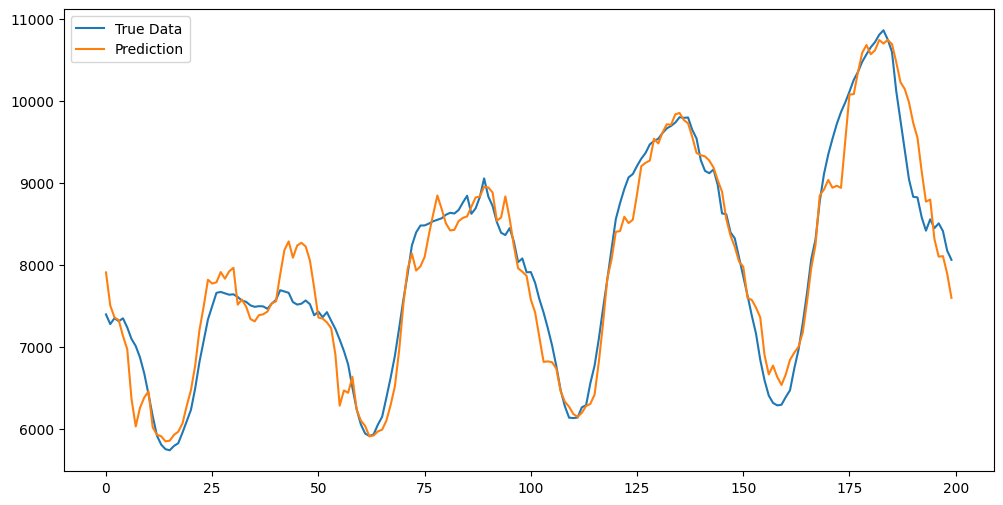

In [20]:
import numpy as np

def main():
    data_path = '/content/drive/MyDrive/ausdata.csv'
    P = 24  #sequence length
    step = 6 #ahead predict steps

    X_train,Y_train,X_test,Y_test,data_df_combined_clean = load_data(data_path,P=P,step=step)
    print(X_train.shape)
    print(Y_train.shape)
    
    model = Wavelet_LSTM(P,100,1)#seq_len, hidden_size,output_size
    model = model.double()
    train(model,X_train,Y_train,epochs=50)
    test(model,X_test,Y_test,data_df_combined_clean)


if __name__ == "__main__":
    main()